# Creation de netcdf a partir de sorties ParFlow (.pfb)
Le format natif des sorties ParFlow est le .pfb. Ce sont des matrices binaires composées d'un en-tête et de la matrice (1D, 2D, ou 3D)

In [1]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt

In [3]:
from parflow import tools as tls

ModuleNotFoundError: No module named 'parflow'

fonction pour lire un .pfb:

In [ ]:
def PFB_read(pfb_file_path, flag):

    #print("**This code DOES handle subgrids**")
    # flag = 1: return array + header
    # flag = 0: return array only
    
    hdr_dict = {}
    
    with open(pfb_file_path,'rb') as pfbf:
        hdr_dict['X0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Y0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Z0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['nx'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['ny'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['nz'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['dx'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dy'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dz'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['ns'] = struct.unpack('>i', pfbf.read(4))[0]
        ns = hdr_dict['ns']
        #print(ns)
        nx = hdr_dict['nx']
        ny = hdr_dict['ny']
        nz = hdr_dict['nz']
        
        if nx == 0:
            nx = int(raw_input("What should the NX be?"))
            hdr_dict['nx'] = nx
        if ny == 0:
            ny = int(raw_input("What should the NY be?"))
            hdr_dict['ny'] = ny
        if nz ==0:
            nz =int(raw_input("What should the NZ be?"))
            hdr_dict['nz'] = nz
        
        X0 = hdr_dict['X0']
        #print "len_x, len_y, len_z, nx ny nz --> %f %f %f %i %i %i" %(len_x, len_x, len_x, nx, ny, nz)
        
        pfb_array = np.zeros((nx, ny, nz))
        
        for subgrids in range(ns):
            hdr_dict['ix'] = struct.unpack('>i', pfbf.read(4))[0]
            ix = hdr_dict['ix']
            hdr_dict['iy'] = struct.unpack('>i', pfbf.read(4))[0]
            iy = hdr_dict['iy']
            #print(iy)
            hdr_dict['iz'] = struct.unpack('>i', pfbf.read(4))[0]
            iz = hdr_dict['iz']
            hdr_dict['nx2'] = struct.unpack('>i', pfbf.read(4))[0]
            nx2 = hdr_dict['nx2']
            hdr_dict['ny2'] = struct.unpack('>i', pfbf.read(4))[0]
            ny2 = hdr_dict['ny2']
            #print(ny2)
            hdr_dict['nz2'] = struct.unpack('>i', pfbf.read(4))[0]
            nz2 = hdr_dict['nz2']
            hdr_dict['rx'] = struct.unpack('>i', pfbf.read(4))[0]
            rx = hdr_dict['rx']
            hdr_dict['ry'] = struct.unpack('>i', pfbf.read(4))[0]
            ry = hdr_dict['ry']
            hdr_dict['rz'] = struct.unpack('>i', pfbf.read(4))[0]
            rz = hdr_dict['rz']
            #print "ix iy iz nx2 ny2 nz2 rx ry rz --> %i %i %i %i %i %i %i %i %i\n" %(ix,iy, iz, nx2, ny2, nz2, rx,ry, rz)
            for lays in range(nz2):
                for rows in range(ny2):
                    for cols in range(nx2):
                        val = struct.unpack('>d', pfbf.read(8))[0]
                        #q = raw_input(val)
                        pfb_array[(cols+ix), (rows + iy), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(cols+ix-1), (nx2-(iy)-1), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(rows + iy-1), (cols+ix-1), (nz2-(lays + iz)-1)] = val
                        #print val
                        
    if flag ==1:
        return(pfb_array, hdr_dict)
    else:
        return(pfb_array)


Quelques paramètres de simulation

In [ ]:
datadir = '/home/hectorb/PARFLOW/PROJECTS/Hillslope/wankama/results/'
obsdir = "/home/hectorb/DATA/METEO/Niger/AMMA-CATCH/data/NAD_dataset/"

n_coupled_layers = 22

dz_mult_arr,h = PFB_read(glob.glob(os.path.join(datadir,'*dz_mult.pfb'))[0],1)
vdz = dz_mult_arr[0,0,:]
z = np.cumsum(vdz)-vdz/2
print(vdz)
print(z)
print(np.cumsum(vdz))

## Lecture des fichiers pression: 

In [4]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*press.*.pfb'))
files.sort()
#skip initial condition
files.pop(0)

'/home/hectorb/PARFLOW/PROJECTS/Hillslope/wankama/results/wank2D.out.press.00000.pfb'

In [5]:
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
print(h)

{'X0': 0.0, 'Y0': 0.0, 'Z0': 0.0, 'nx': 1, 'ny': 20, 'nz': 24, 'dx': 100.0, 'dy': 100.0, 'dz': 1.0, 'ns': 1, 'ix': 0, 'iy': 0, 'iz': 0, 'nx2': 1, 'ny2': 20, 'nz2': 24, 'rx': 0, 'ry': 0, 'rz': 0}


In [6]:
pressure_array = np.zeros([h['ny'],h['nz'],len(files)])
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    pressure_array[:,:,t] = d[0,:,:]

## Ecriture des pressions: 

In [7]:
"""write netcdf"""
ds = xr.Dataset({"press": (("time","z",'y'), np.swapaxes(pressure_array,2,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "z":-z, 
        "time": pd.date_range("2000-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2000-01-01")})

ds.press.attrs['units']='m'
ds.z.attrs['units']='meters'
ds.y.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"press.nc"),format="NETCDF4")

## Lecture des fichiers saturation: 

In [8]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*satur.*.pfb'))
files.sort()
#skip initial condition
files.pop(0)
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)

In [9]:
satur_array = np.zeros([h['ny'],h['nz'],len(files)])
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    satur_array[:,:,t] = d[0,:,:]

## Ecriture des saturations: 

In [10]:
"""write netcdf"""
ds = xr.Dataset({"satur": (("time","z",'y'), np.swapaxes(satur_array,2,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "z":-z, 
        "time": pd.date_range("2000-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2000-01-01")})

ds.satur.attrs['units']='[-]'
ds.z.attrs['units']='meters'
ds.y.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"satur.nc"),format="NETCDF4")

## Evolution de la saturation

In [12]:
import hvplot.xarray
#interpolation optionnelle:
ds2 = ds.interp(z=np.arange(0,-50,-0.2),method='linear')

ds2.satur.hvplot.quadmesh(x='y',y='z',groupby="time",clim=(0,1),widget_type="scrubber",widget_location="bottom",)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=399, width=550)
        [2] HSpacer()

## Extraction des niveaux de nappe

In [12]:
ds = xr.open_dataset(os.path.join(datadir,"press.nc"))
ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

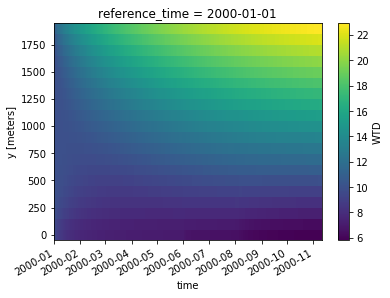

In [13]:
ds.WTD.plot(x='time')

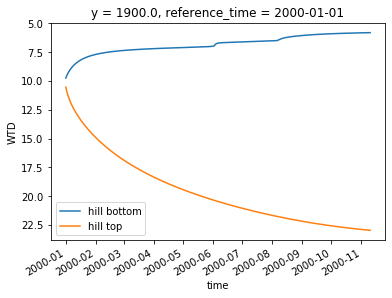

In [14]:
from matplotlib import pyplot as plt
ds.WTD.isel(y=0).plot(label='hill bottom')
ds.WTD.isel(y=19).plot(label='hill top')
plt.gca().legend()
plt.gca().invert_yaxis()

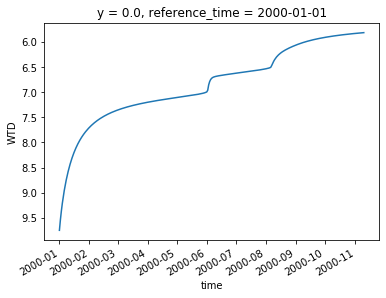

In [15]:
ds.WTD.isel(y=0).plot(label='hill bottom')
plt.gca().invert_yaxis()

## Lecture des débits journaliers

In [16]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*overlandsum.*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
runoff = pd.Series(index=pd.date_range("2000-01-01", periods=len(files)))
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    runoff.iloc[t] = np.sum(d[0,:,0])
print(np.shape(d))

(1, 20, 1)


/home/hectorb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


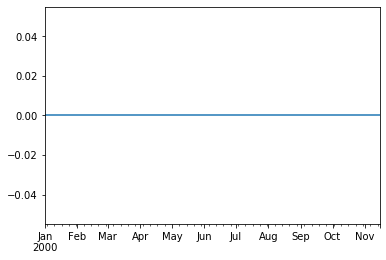

In [17]:
runoff.plot()

## Lecture des variables CLM (evapotranspiration, notamment)
Dans le manuel, les variables CLM écrites sont :
- *eflx_lh_tot* for latent heat flux total [W/m 2 ] 
- *eflx_lwrad_out* for outgoing long-wave radiation [W/m 2 ] 
- *eflx_sh_tot* for sensible heat flux total [W/m 2 ] 
- *eflx_soil_grnd* for ground heat flux [W/m 2 ] 
- *qflx_evap_tot* for total evaporation [mm/s] 
- *qflx_evap_grnd* for ground evaporation without condensation [mm/s] 
- *qflx_evap_soi* for soil evaporation [mm/s] 
- *qflx_evap_veg* for vegetation evaporation [mm/s] 
- *qflx_tran_veg* for vegetation transpiration [mm/s]
- *qflx_infl* for soil infiltration [mm/s]
- *swe_out* for snow water equivalent [mm]
- *t_grnd* for ground surface temperature [K]
- *t_soil* for soil temperature over all layers [K] 

In [18]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*clm_output*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
evaptot_array = np.zeros([h['ny'],len(files)])
evapveg_array = np.zeros([h['ny'],len(files)])
evapsoi_array = np.zeros([h['ny'],len(files)])
print(d.shape)
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    evaptot_array[:,t] = d[0,:,-5]*60*60
    evapveg_array[:,t] = d[0,:,-8]*60*60
    evapsoi_array[:,t] = d[0,:,-7]*60*60


(1, 20, 35)


## Ecriture des sorties CLMs

In [19]:
"""write netcdf"""
ds = xr.Dataset({"evaptot": (("time","y"), np.swapaxes(evaptot_array,1,0)),
                 "evapveg": (("time","y"), np.swapaxes(evapveg_array,1,0)),
                 "evapsoil": (("time","y"), np.swapaxes(evapsoi_array,1,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "time": pd.date_range("2000-01-01", periods=len(files),freq='1H'),
        "reference_time": pd.Timestamp("2000-01-01")})

ds.evaptot.attrs['units']='mm/h'
ds.evapveg.attrs['units']='mm/h'
ds.evapsoil.attrs['units']='mm/h'
ds.y.attrs['units']='meters'

ds.to_netcdf(os.path.join(datadir,"evapotranspiration.nc"),format="NETCDF4")

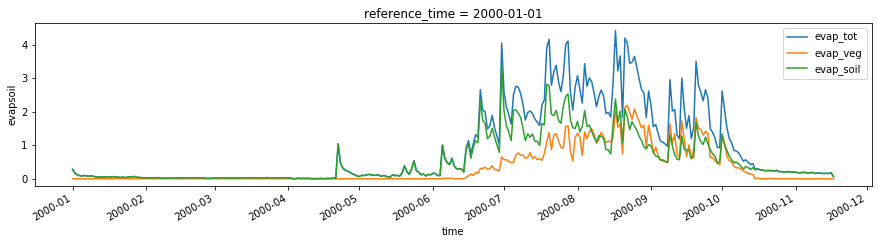

In [20]:
fig, ax = plt.subplots(figsize=(15,3))
ds.evaptot.mean(dim='y').resample(time='D').sum().plot(label='evap_tot')
ds.evapveg.mean(dim='y').resample(time='D').sum().plot(label='evap_veg')
ds.evapsoil.mean(dim='y').resample(time='D').sum().plot(label='evap_soil')
a = plt.gca()
a.legend()


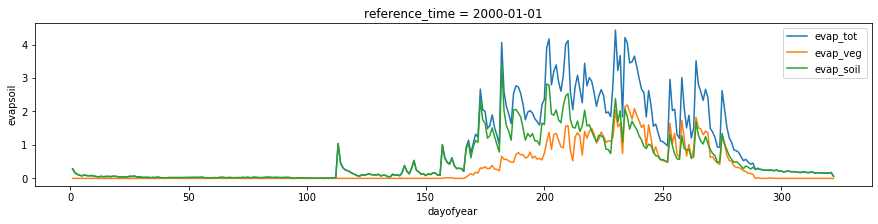

In [21]:
fig, ax = plt.subplots(figsize=(15,3))
ds.evaptot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_tot')
ds.evapveg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_veg')
ds.evapsoil.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(label='evap_soil')
a = plt.gca()
a.legend()

### Comparaison avec les données

In [22]:
import datetime
obs = pd.read_csv(obsdir + "NAD-Sf_1.txt", delim_whitespace=True, header = None,\
names = ['year','DoY','hour','minute','LWup','SWup','H','LE','Ts','G'], index_col = None)
obs = obs.iloc[48*365*50::,:]
obs.index = obs.apply(lambda x: datetime.datetime(int(x['year']),1,1)+datetime.timedelta(days=x['DoY'],seconds=x['hour']*3600+x['minute']*60) - datetime.timedelta(days=1),axis=1)  
obs = obs.loc[obs.index>=datetime.datetime(2000,1,1,0,0,0),:]
# CLM: hvap   = 2.5104e06 !Latent heat of evap for water [J/kg]
# see also, for a formula including Tair:
# https://search.r-project.org/CRAN/refmans/bigleaf/html/latent.heat.vaporization.html
# https://search.r-project.org/CRAN/refmans/bigleaf/html/LE.to.ET.html
# W = J / s
# ET [kg/m2/s] = LE [J/m2/s] / lambda [J/kg]
# ET [mm/h] = 3600 * ET [kg/m2/s]
obs['ET'] = 3600*obs['LE']/2.5104e06

print(obs)

                     year  DoY  hour  minute   LWup  SWup     H   LE     Ts  \
2000-01-01 00:00:00  2000    1     0       0  411.4   0.0  -0.8  1.1  297.9   
2000-01-01 00:30:00  2000    1     0      30  407.1   0.0  -0.7  4.4  297.4   
2000-01-01 01:00:00  2000    1     1       0  403.5   0.0  -7.6  8.7  296.9   
2000-01-01 01:30:00  2000    1     1      30  401.0   0.0  -1.7  3.6  296.4   
2000-01-01 02:00:00  2000    1     2       0  398.1   0.0  -0.9  3.1  296.0   
...                   ...  ...   ...     ...    ...   ...   ...  ...    ...   
2009-12-31 22:00:00  2009  365    22       0  421.0   0.0 -14.0  5.0  299.9   
2009-12-31 22:30:00  2009  365    22      30  419.4   0.0 -18.2  4.8  299.5   
2009-12-31 23:00:00  2009  365    23       0  417.1   0.0 -13.3  4.7  299.1   
2009-12-31 23:30:00  2009  365    23      30  417.6   0.0 -23.2  4.6  298.7   
2010-01-01 06:30:00  2009  365    30      30  417.6   0.0 -23.2  4.6  298.7   

                        G        ET  
2000-01-01 00

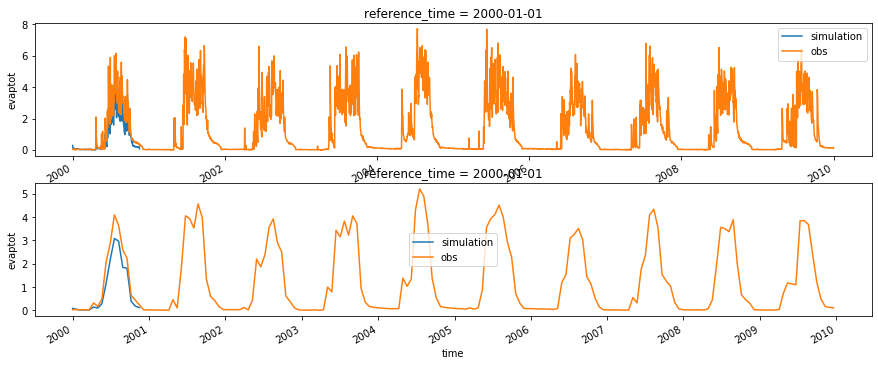

In [23]:
fig, ax = plt.subplots(2,1,figsize=(15,6))
ds.evaptot.mean(dim='y').resample(time='D').sum().plot(ax=ax[0],label='simulation')
(obs.ET.resample('D').mean()*24).plot(ax=ax[0],label='obs')

ax[0].legend()
ds.evaptot.mean(dim='y').resample(time='D').sum().resample(time='20D').mean().plot(ax=ax[1],label='simulation')
(obs.ET.resample('20D').mean()*24).plot(ax=ax[1],label='obs')
ax[1].legend()

## Lecture de l'évapotranspiration journaliere

In [24]:
"""identify files"""
files = glob.glob(os.path.join(datadir,'*evaptranssum.*.pfb'))
files.sort()
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
ETsum = pd.Series(index=pd.date_range("2000-01-01", periods=len(files)))
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    tmp = np.zeros([h['ny']])
    for k in range(n_coupled_layers):
        tmp+=d[0,:,k]*vdz[k]
    ETsum.iloc[t] = np.mean(tmp)
print(d[0,0,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/hectorb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


## Lecture des forçages:

In [25]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(glob.glob(os.sep.join([datadir,'*forc*txt*']))[0],header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2000 00:00:00', periods=len(forc), freq='30min')
P=forc['P']*30*60

In [26]:
""" correction de l'ET """
ETsum = ETsum*1000/h['dx']/h['dy'] #m3 -> mm

In [27]:
ET = -(ETsum -P.resample('D').sum())

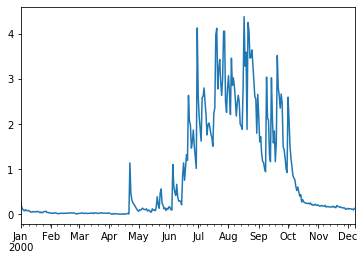

In [28]:
ET.dropna().plot()

## Calcul de la variation de stock

In [29]:
## lectures de variables auxiliaires: 
poro,h=PFB_read(glob.glob(os.path.join(datadir,'*poro*.pfb'))[0],1)
specstor,h=PFB_read(glob.glob(os.path.join(datadir,'*specific*.pfb'))[0],1)
dz_mult_arr,h = PFB_read(glob.glob(os.path.join(datadir,'*dz_mult.pfb'))[0],1)
dz_mult_arr.shape

(1, 20, 24)

In [30]:

# loop over time
nt = satur_array.shape[-1]

stock = np.zeros([nt])
for t in range(nt):
    # underground storage
    stock[t] = (h['dx']*h['dy']*h['dz']*dz_mult_arr[0,:,:]*poro[0,:,:]*satur_array[:,:,t]).sum(axis=0).sum(axis=0)
    # poroelastic storage
    tmp1 = (h['dx']*h['dy']*h['dz']*dz_mult_arr[0,:,:]*specstor[0,:,:]*satur_array[:,:,t]*pressure_array[:,:,t])
    #~ tmp[tmp<0]=0.
    stock[t]+=tmp1.sum(axis=0).sum(axis=0)
    # surface storage
    tmp2 = h['dx']*h['dy']*pressure_array[:,0,t]
    tmp2[tmp2<0]=0
    stock[t]+=tmp2.sum(axis=0)

In [31]:
stock = stock * 1000/h['dx']/h['dy']/h['ny']
stock = stock-stock[0]
#stock = stock[1::]
stock = pd.Series(stock)
#stock.index=pd.date_range('1/1/2005 00:00:00', periods=nt-1, freq='D')
stock.index=pd.date_range('1/1/2000 00:00:00', periods=nt, freq='D')

stock = stock.sort_index()

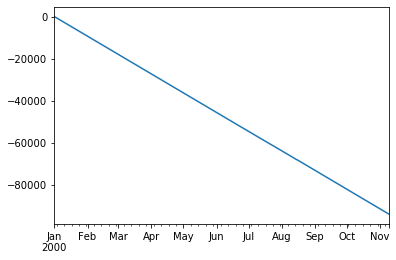

In [32]:
stock.plot()

## Calcul du bilan

In [33]:
Q = runoff* 1000/h['dx']/h['dy']/h['ny']
Budg = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET.resample('Y').sum(),'Q':Q.resample('Y').sum(),'WSC':np.nan})
for i, y in enumerate(np.sort(stock.index.year.unique())):
    if i ==0:
         Budg['WSC'][Budg.index.year==y] = stock[stock.index.year==y][-1]
    else:
         Budg['WSC'][Budg.index.year==y] = stock[stock.index.year==y][-1] - stock[stock.index.year==y-1][-1] 
Budg.index=Budg.index.year
Budg['closure'] = Budg['P']- Budg['ET']-Budg['Q']-Budg['WSC']
Budg

P          ET    Q           WSC     closure
2000  443.70  291.044487  0.0 -94042.811788  94195.4673
2001  643.32    0.000000  NaN           NaN         NaN
2002  476.82    0.000000  NaN           NaN         NaN
2003  614.88    0.000000  NaN           NaN         NaN
2004  748.26    0.000000  NaN           NaN         NaN
2005  701.82    0.000000  NaN           NaN         NaN
2006  399.06    0.000000  NaN           NaN         NaN
2007  560.88    0.000000  NaN           NaN         NaN
2008  423.72    0.000000  NaN           NaN         NaN
2009  519.30    0.000000  NaN           NaN         NaN
2010    0.00    0.000000  NaN           NaN         NaN

In [34]:
def plot_clustered_stacked(dfall, labels=None,  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(10,4))
    axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        if isinstance(df, pd.DataFrame):
            axe = df.plot(kind="bar",
            linewidth=0,
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs)  # make bar plots
        else:
             axe = df.plot(kind="bar",
             linewidth=0,
             stacked=True,
             ax=axe,
             legend=False,
             grid=False,
	     color='b',
             **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


Text(0, 0.5, 'mm')

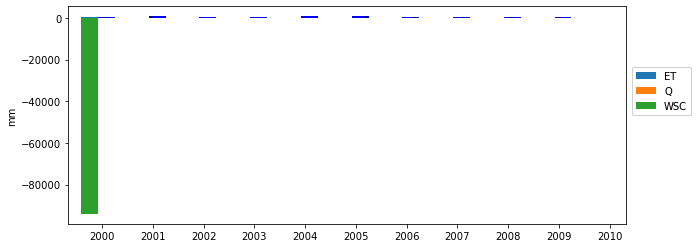

In [35]:
ax=plot_clustered_stacked([Budg.loc[:,['ET','Q','WSC']],Budg['P']])
ax.set_ylabel('mm')